In [100]:
%matplotlib inline
%load_ext sql

import pandas as pd 
import pylab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import sklearn
from scipy.stats import mode
import psycopg2 as psy
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sqlalchemy.engine.url import URL
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA 
import matplotlib.patheffects as path_effects

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


# Problem Statement

We were tasked with finding structures in the data provided, and also perhaps factors which help identify lengthy delays for departures and arrivals.

## Fun with psql

In [2]:
# Reading in all the CSV files in from csv files and then preparing them for uploading into psql
cancels = pd.read_csv('../assets/airport_cancellations.csv')
cancels.columns = [c.lower().replace(' ','') for c in cancels.columns] #postgres doesn't like capitals or spaces
ops = pd.read_csv('../assets/Airport_operations.csv')
ops.columns = [c.lower().replace(' ','') for c in ops.columns] #postgres doesn't like capitals or spaces
airports = pd.read_csv('../assets/airports.csv')
airports.columns = [c.lower().replace(' ','') for c in airports.columns] #postgres doesn't like capitals or spaces

In [3]:
# checking the shape of the respective tables
print(cancels.shape)
print(ops.shape)
print(airports.shape)

(805, 6)
(841, 15)
(5167, 13)


In [4]:
engine = create_engine('postgresql://@localhost:5432/airports')

In [5]:
%%sql
postgresql://@localhost:5432/airports

u'Connected: @airports'

In [ ]:
airports.to_sql('airports', engine)
ops.to_sql('ops', engine)
cancels.to_sql('cancels', engine)

In [6]:
%%sql   
SELECT * FROM ops LIMIT 2

2 rows affected.


[(0L, u'ABQ', 2004L, 53971L, 53818L, 0.803, 0.7809, 0.7921, 10.38, 9.89, 2.43, 12.1, 2.46, 0.83, 2.55, 10.87),
 (1L, u'ABQ', 2005L, 51829L, 51877L, 0.814, 0.7922, 0.8001, 9.6, 9.79, 2.29, 11.2, 2.26, 0.89, 2.34, 10.24)]

In [7]:
%%sql 
SELECT * FROM airports LIMIT 2

2 rows affected.


[(0L, 3443.0, u'STX', u'HENRY E ROHLSEN', u"Henry E Rohlsen Int'l Airport", u'Airport', u'ASO', u'-VIRGIN ISLANDS-', u'CHRISTIANSTED', u'VI', u'Public Use', 17.701556, -64.801722, u'Yes'),
 (1L, 5088.0, u'X64', u'PATILLAS', None, u'Airport', u'ASO', u'#NAME?', u'PATILLAS', u'PR', u'Public Use', 17.982189, -66.01933, u'No')]

In [8]:
%%sql        
SELECT * FROM cancels LIMIT 2

2 rows affected.


[(0L, u'ABQ', 2004.0, 242.0, 235.0, 71.0, 46.0),
 (1L, u'ABQ', 2005.0, 221.0, 190.0, 61.0, 33.0)]

In [10]:
%%sql
SELECT * FROM airports a, cancels c WHERE c."airport" = a."locid" LIMIT 2

2 rows affected.


[(10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\ufffdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes', 727L, u'SJU', 2014.0, 280.0, 241.0, 72.0, 31.0),
 (10L, 2885.0, u'SJU', u'LUIS MUNOZ MARIN INTL', u"Aeropuerto Int'l Luis Mu\ufffdoz Marin", u'Airport', u'ASO', u'#NAME?', u'SAN JUAN', u'PR', u'Federalized/Commercial', 18.439295, -66.002004, u'Yes', 726L, u'SJU', 2013.0, 127.0, 94.0, 65.0, 64.0)]

## Done with psql, now going back into python

In [11]:
df = pd.merge(ops, cancels, left_on=['airport', 'year'], right_on=['airport', 'year'], how='outer')

In [12]:
sum(df.airport.value_counts())

847

In [13]:
df.shape

(847, 19)

In [14]:
df.isnull().sum()

airport                             0
year                                0
departuresformetriccomputation      6
arrivalsformetriccomputation        6
percenton-timegatedepartures        6
percenton-timeairportdepartures     6
percenton-timegatearrivals          6
average_gate_departure_delay        6
average_taxi_out_time               6
averagetaxioutdelay                 6
averageairportdeparturedelay        6
averageairbornedelay                6
averagetaxiindelay                  6
averageblockdelay                   6
averagegatearrivaldelay             6
departurecancellations             42
arrivalcancellations               42
departurediversions                42
arrivaldiversions                  42
dtype: int64

In [15]:
df= df[df['departurecancellations'].isnull() != True]
df= df[df['departuresformetriccomputation'].isnull() != True]

In [16]:
df = pd.merge(df, airports, left_on='airport', right_on ='locid', how='left')

In [17]:
df.shape

(799, 32)

In [18]:
df.isnull().sum()

airport                            0
year                               0
departuresformetriccomputation     0
arrivalsformetriccomputation       0
percenton-timegatedepartures       0
percenton-timeairportdepartures    0
percenton-timegatearrivals         0
average_gate_departure_delay       0
average_taxi_out_time              0
averagetaxioutdelay                0
averageairportdeparturedelay       0
averageairbornedelay               0
averagetaxiindelay                 0
averageblockdelay                  0
averagegatearrivaldelay            0
departurecancellations             0
arrivalcancellations               0
departurediversions                0
arrivaldiversions                  0
key                                0
locid                              0
ap_name                            0
alias                              0
facilitytype                       0
faaregion                          0
county                             0
city                               0
s

In [19]:
del df['key']
del df['locid']
del df['ap_name']
del df['alias']
del df['facilitytype']
del df['boundarydataavailable']

In [20]:
df.columns

Index([u'airport', u'year', u'departuresformetriccomputation',
       u'arrivalsformetriccomputation', u'percenton-timegatedepartures',
       u'percenton-timeairportdepartures', u'percenton-timegatearrivals',
       u'average_gate_departure_delay', u'average_taxi_out_time',
       u'averagetaxioutdelay', u'averageairportdeparturedelay',
       u'averageairbornedelay', u'averagetaxiindelay', u'averageblockdelay',
       u'averagegatearrivaldelay', u'departurecancellations',
       u'arrivalcancellations', u'departurediversions', u'arrivaldiversions',
       u'faaregion', u'county', u'city', u'state', u'aptype', u'latitude',
       u'longitude'],
      dtype='object')

In [23]:
df.columns = [u'airport', u'year', u'numDepartures',
       u'numArrivals', u'pctOntimeGateDepartures',
       u'pctOntimeAptDepartures', u'pctOntimeGateArrivals',
       u'avgGateDepartureDelay', u'avgTaxiOutTime',
       u'avgTaxiOutDelay', u'avgAptDepartureDelay',
       u'avgAirborneDelay', u'avgTaxiInDelay',
       u'avgBlockDelay', u'avgGateArrivalDelay',
       u'departureCancellations', u'arrivalCancellations',
       u'departureDiversions', u'arrivalDiversions', u'FAAregion',
       u'county', u'city', u'state', u'APtype', u'latitude', u'longitude']

In [24]:
# Sub-dataframe for arrival data
a_df = df[[u'airport', u'year',
       u'numArrivals', u'pctOntimeGateArrivals',
       u'avgGateArrivalDelay', u'arrivalCancellations',
       u'arrivalDiversions']]

In [25]:
# Sub-dataframe for departure data
d_df = df[[u'airport', u'year', u'numDepartures',
       u'pctOntimeGateDepartures',
       u'pctOntimeAptDepartures', 
       u'avgGateDepartureDelay', u'avgTaxiOutTime',
       u'avgTaxiOutDelay', u'avgAptDepartureDelay',
       u'avgAirborneDelay', u'avgTaxiInDelay',
       u'avgBlockDelay',
       u'departureCancellations',
       u'departureDiversions',]]

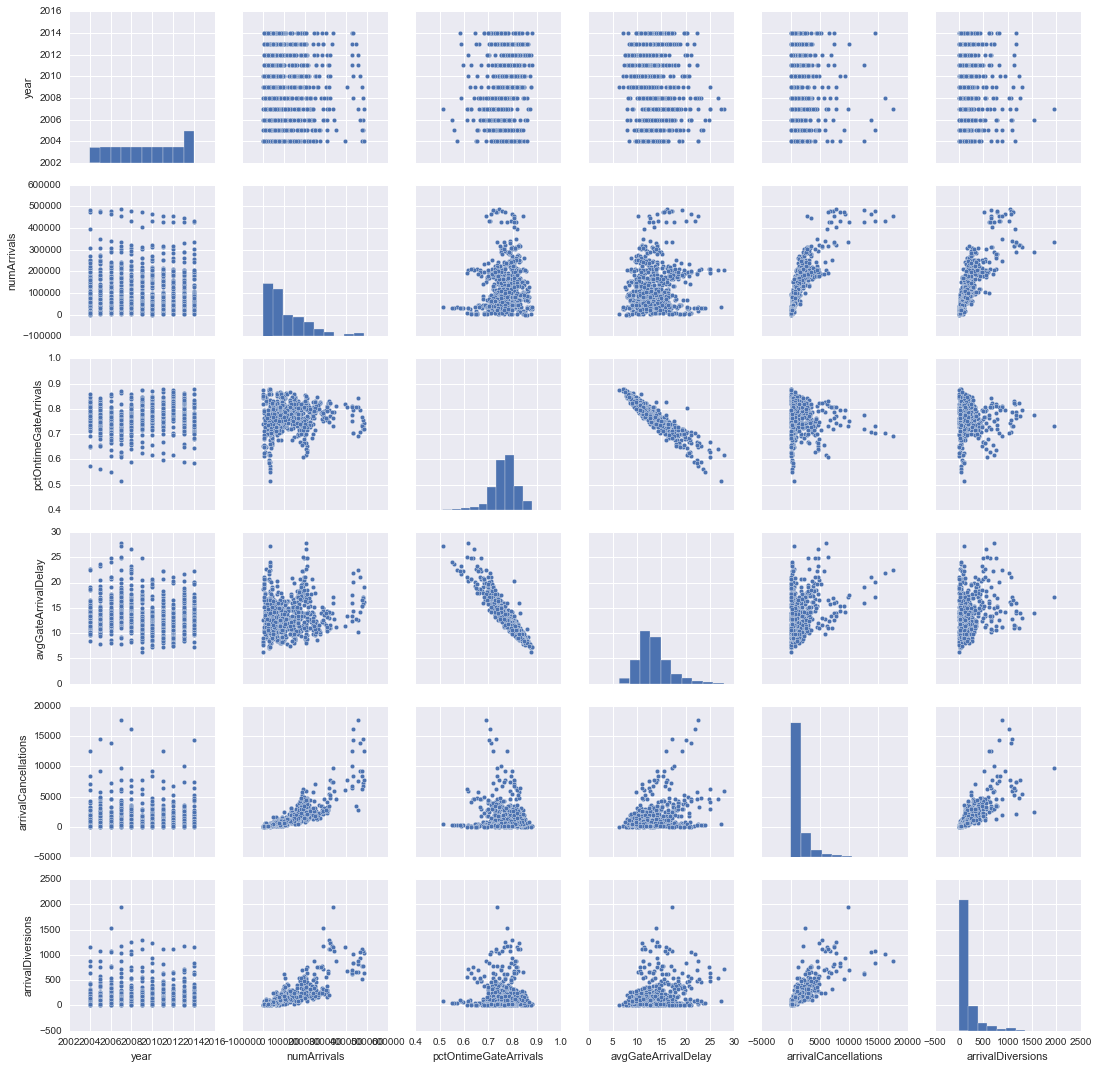

In [26]:
sns.pairplot(a_df)

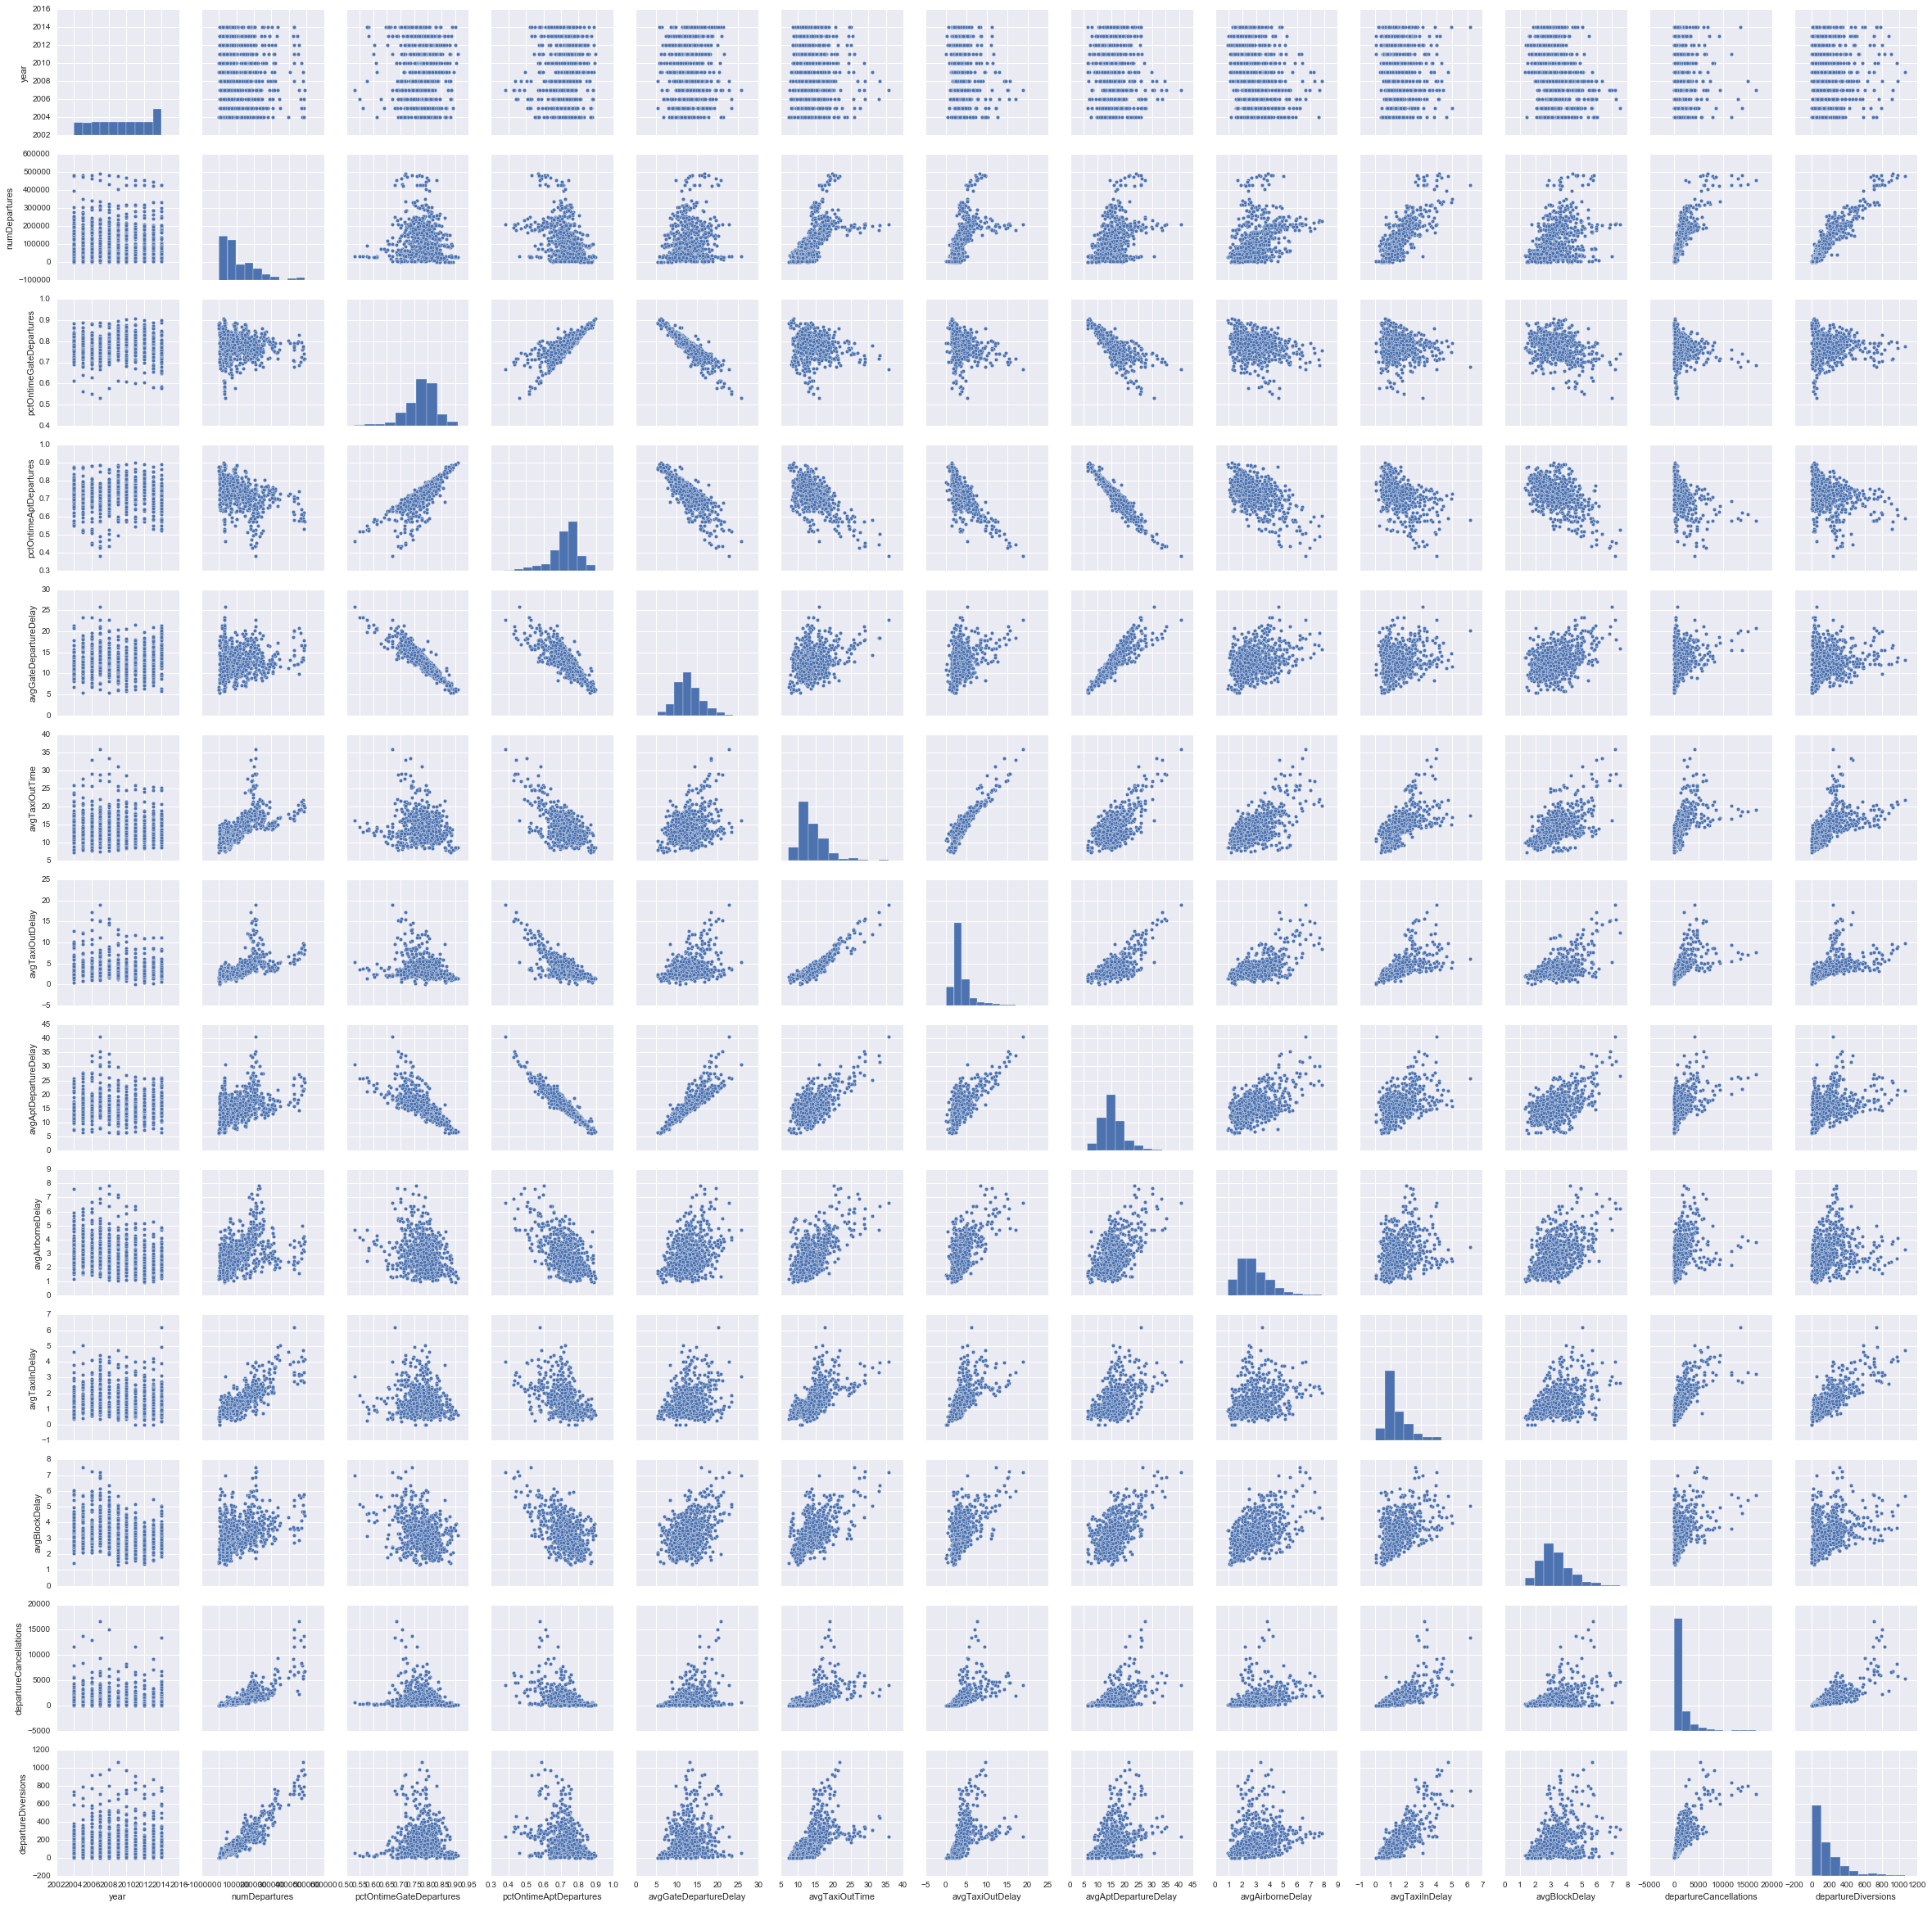

In [27]:
sns.pairplot(d_df)

## Cleaning and Munging

In [28]:
cols_to_keep = [u'year', u'numDepartures',
       u'numArrivals', u'pctOntimeGateDepartures',
       u'pctOntimeAptDepartures', u'pctOntimeGateArrivals',
       u'avgGateDepartureDelay', u'avgTaxiOutTime',
       u'avgTaxiOutDelay', u'avgAptDepartureDelay',
       u'avgAirborneDelay', u'avgTaxiInDelay',
       u'avgBlockDelay', u'avgGateArrivalDelay',
       u'departureCancellations', u'arrivalCancellations',
       u'departureDiversions', u'arrivalDiversions', u'latitude', u'longitude']

# Dummy-ing in a smart way the Genres (get_dummies does it too messy)
cv = CountVectorizer()
data = cv.fit_transform(df.county).todense()
columns = ['county_'+c for c in cv.get_feature_names()]
countydf = pd.DataFrame(data, columns=columns)

# countydf = df[['county']]
# countydf = pd.get_dummies(countydf)

statedf = df[['state']]
statedf = pd.get_dummies(statedf)

APtypedf = df[['APtype']]
APtypedf = pd.get_dummies(APtypedf)

FAAdf = df[['FAAregion']]
FAAdf = pd.get_dummies(FAAdf)

In [29]:
# Setting y here, can choose between FAAregion, airport, city, but cannot do county or state
# because we're dummifying those and adding them to X

y = LabelEncoder().fit_transform(df['airport'])
# y = df['airport']

In [30]:
# Putting into numpy array form for the analysis
x = df[cols_to_keep]
X = StandardScaler().fit_transform(x.astype(float))
X = pd.DataFrame(X, columns = cols_to_keep)
Xpca = X.copy()
# X = pd.concat([X, countydf, statedf, APtypedf, FAAdf], axis =1)

In [31]:
X.head(2)

year  numDepartures  numArrivals  pctOntimeGateDepartures  \
0 -1.593401      -0.607163    -0.606139                 0.457014   
1 -1.275754      -0.629020    -0.626018                 0.667555   

   pctOntimeAptDepartures  pctOntimeGateArrivals  avgGateDepartureDelay  \
0                0.709963               0.500021              -0.827217   
1                0.858688               0.658531              -1.084255   

   avgTaxiOutTime  avgTaxiOutDelay  avgAptDepartureDelay  avgAirborneDelay  \
0       -1.047069        -0.536544             -0.826210         -0.355457   
1       -1.073359        -0.596479             -1.032562         -0.526543   

   avgTaxiInDelay  avgBlockDelay  avgGateArrivalDelay  departureCancellations  \
0       -0.683889      -0.749327            -0.787421               -0.574713   
1       -0.613645      -0.961737            -0.981290               -0.586128   

   arrivalCancellations  departureDiversions  arrivalDiversions  latitude  \
0             -0.558841            -0.598447          -0.542560 -0.210788   
1             -0.581577            -0.656408          -0.599323 -0.210788   

   longitude  
0  -0.567524  
1  -0.567524

In [32]:
s = []
i = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    labels = kmeans.labels_
    s_i = silhouette_score(X, labels, metric='euclidean')
    s.append(s_i)
    i.append(kmeans.inertia_)

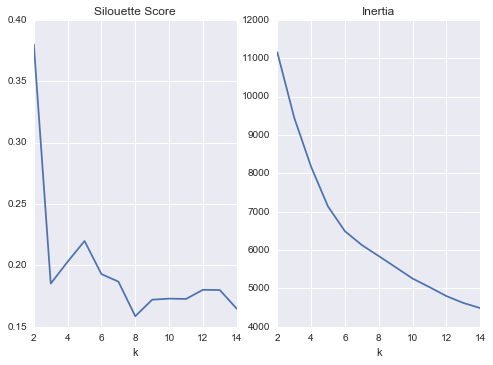

In [33]:
f, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(2,15), s)
ax1.set_title("Silouette Score")
ax1.set_xlabel("k")

ax2.plot(range(2,15), i)
ax2.set_title("Inertia")
ax2.set_xlabel("k")

sns.despine()

In [34]:
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [35]:
d_df['label']=labels
a_df['label'] = labels

/Users/michael/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/michael/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [36]:
d_df.columns

Index([                u'airport',                    u'year',
                 u'numDepartures', u'pctOntimeGateDepartures',
        u'pctOntimeAptDepartures',   u'avgGateDepartureDelay',
                u'avgTaxiOutTime',         u'avgTaxiOutDelay',
          u'avgAptDepartureDelay',        u'avgAirborneDelay',
                u'avgTaxiInDelay',           u'avgBlockDelay',
        u'departureCancellations',     u'departureDiversions',
                         u'label'],
      dtype='object')

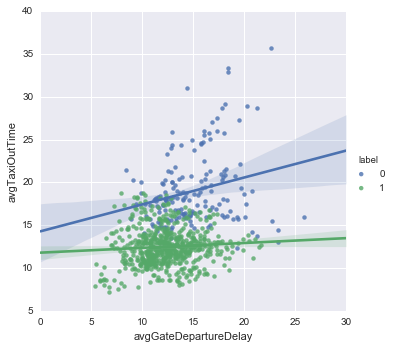

In [37]:
sns.lmplot('avgGateDepartureDelay', 'avgTaxiOutTime', data=d_df,  hue='label')

In [38]:
a_df.columns

Index([              u'airport',                  u'year',
                 u'numArrivals', u'pctOntimeGateArrivals',
         u'avgGateArrivalDelay',  u'arrivalCancellations',
           u'arrivalDiversions',                 u'label'],
      dtype='object')

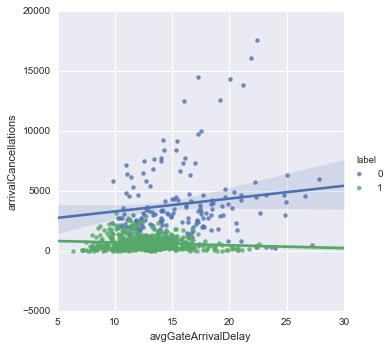

In [39]:
sns.lmplot('avgGateArrivalDelay', 'arrivalCancellations', data=a_df,  hue='label')

In [40]:
silhouette_score(X,labels)

0.38001019837843869

In [41]:
k = 2
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

In [42]:

labels = np.zeros_like(clusters)
for i in range(4):
    mask = (clusters == i)
    labels[mask] = mode(y[mask])[0]

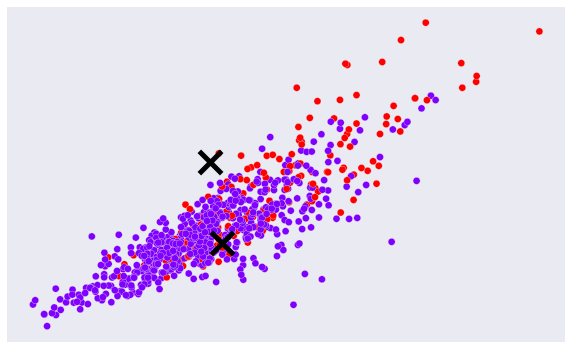

In [43]:
fig, ax = plt.subplots(figsize=(10,6))

plt.scatter(X['avgGateDepartureDelay'], X['avgGateArrivalDelay'], c=labels, s=50, cmap='rainbow');
ax.set_xticks([]);
ax.set_yticks([]);

plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=500, linewidths=5,
            color='k', zorder=10)

## Hierarchical clustering

In [45]:
Xh = X.as_matrix(columns=None)

In [46]:
Z = linkage(Xh, 'complete')

In [47]:
c, coph_dists = cophenet(Z, pdist(Xh))
c

0.76162111349590589

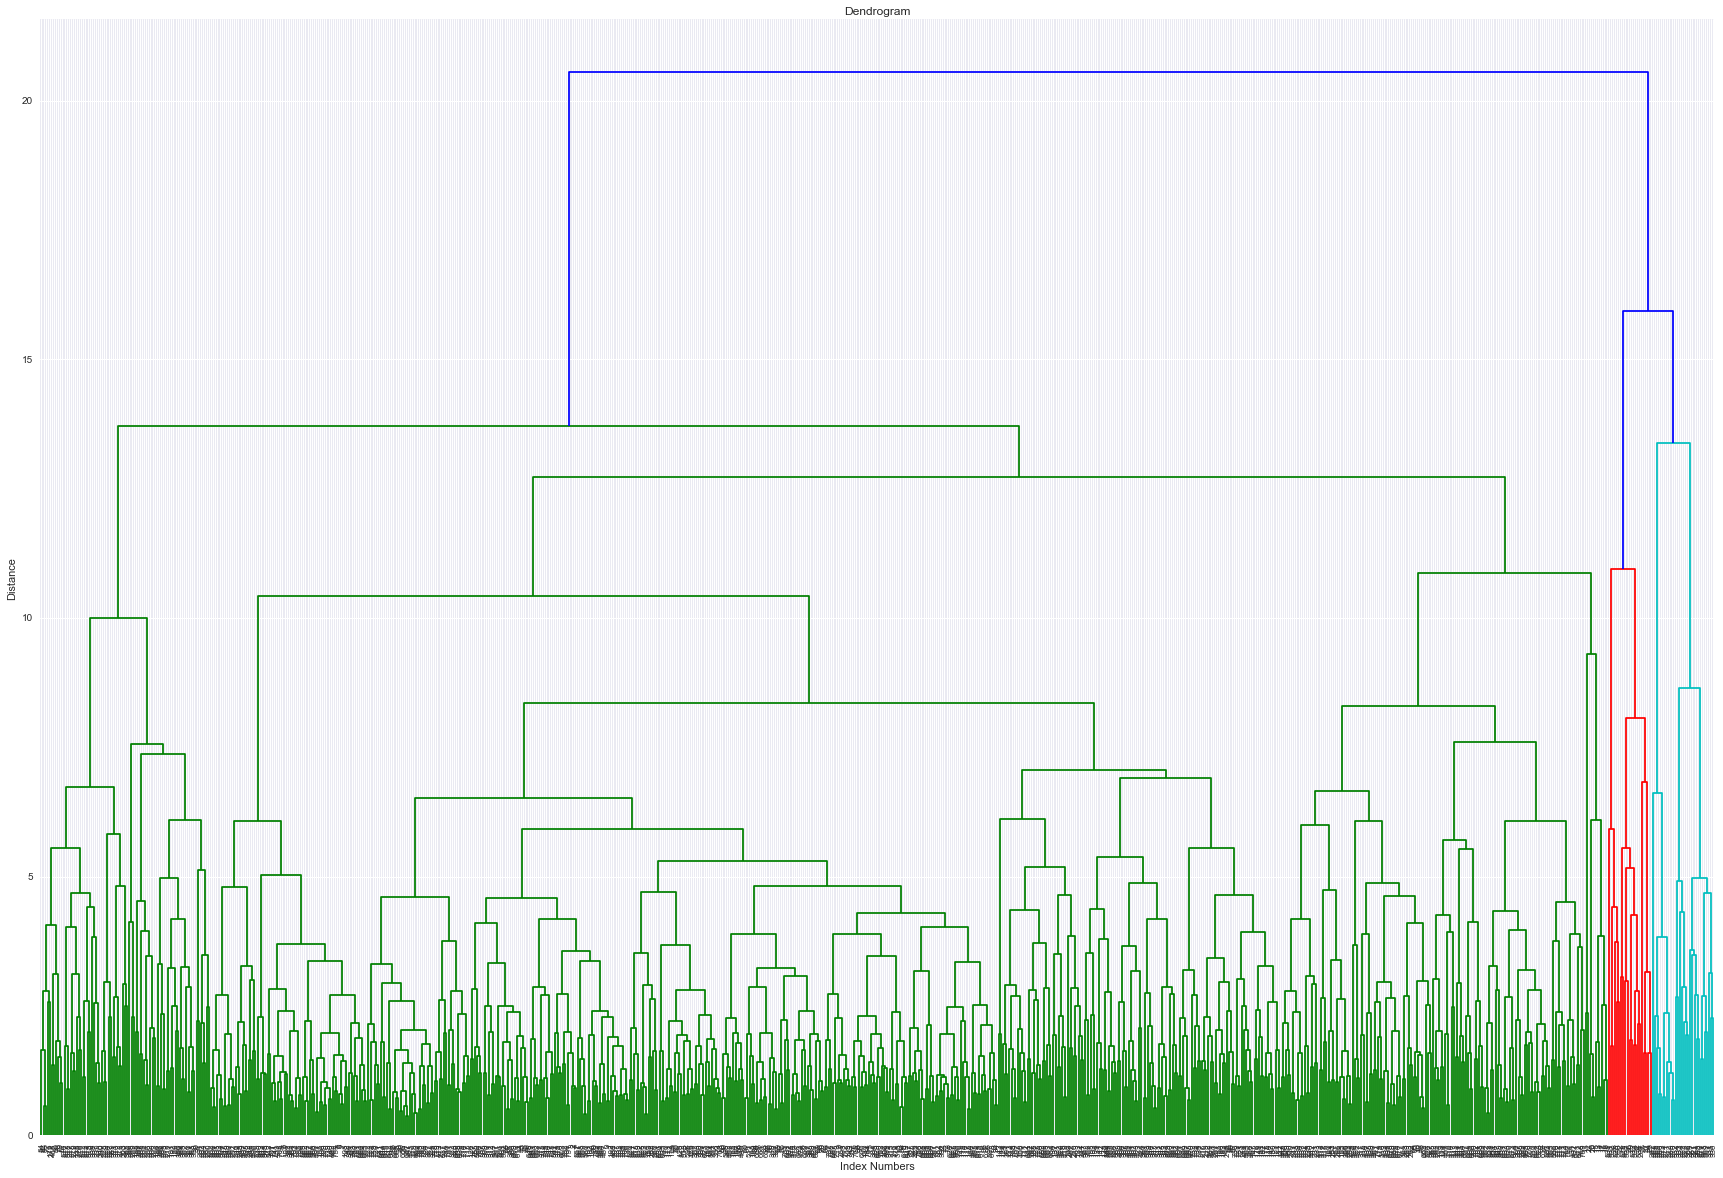

In [50]:
plt.figure(figsize=(30, 20))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

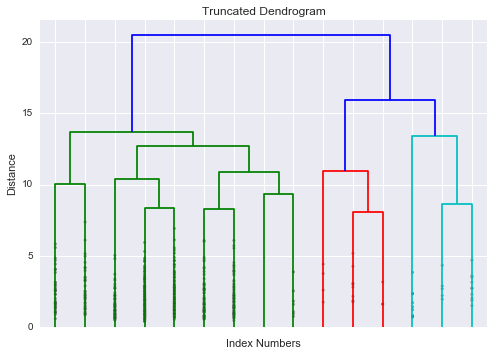

In [51]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

In [52]:
max_d = 20
clusters = fcluster(Z, max_d, criterion='distance')

In [53]:
silhouette_score(X, clusters)

0.50158710423526698

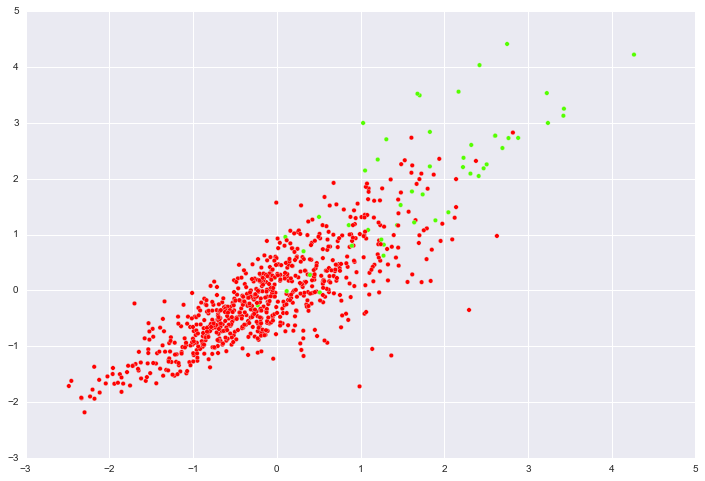

In [54]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(X['avgGateDepartureDelay'], X['avgGateArrivalDelay'], c=clusters, cmap='prism', s=20);

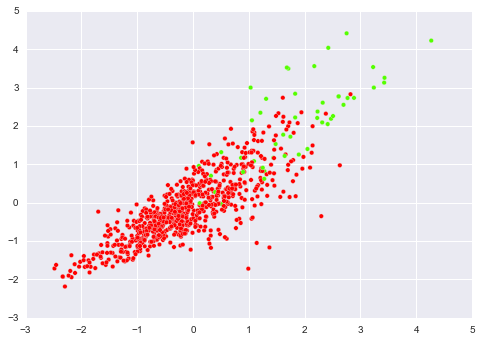

In [55]:
plt.scatter(X['avgGateDepartureDelay'], X['avgGateArrivalDelay'], c=clusters, cmap='prism')
plt.show()

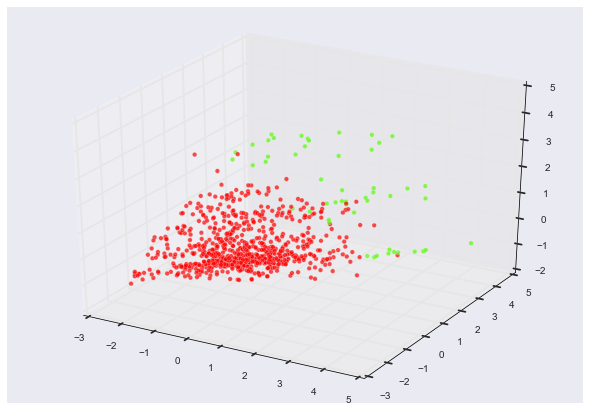

In [56]:
fig = pylab.figure()
ax = Axes3D(fig)
ax.scatter(X['avgGateDepartureDelay'], X['avgGateArrivalDelay'],X['numArrivals'], zdir='z',c=clusters,cmap='prism', alpha=.7, depthshade=True)
plt.show()

## PCA fun

In [57]:
Xpca1 = Xpca.copy()

In [58]:
# Xpca['airport'] = LabelEncoder().fit_transform(df['airport'])
# Xpca['FAAregion'] = LabelEncoder().fit_transform(df['FAAregion'])
# Xpca['APtype'] = LabelEncoder().fit_transform(df['APtype'])
# Xpca['county'] = LabelEncoder().fit_transform(df['county'])
# Xpca['state'] = LabelEncoder().fit_transform(df['state'])

In [59]:
Xpca.head(1).T

0
year                    -1.593401
numDepartures           -0.607163
numArrivals             -0.606139
pctOntimeGateDepartures  0.457014
pctOntimeAptDepartures   0.709963
pctOntimeGateArrivals    0.500021
avgGateDepartureDelay   -0.827217
avgTaxiOutTime          -1.047069
avgTaxiOutDelay         -0.536544
avgAptDepartureDelay    -0.826210
avgAirborneDelay        -0.355457
avgTaxiInDelay          -0.683889
avgBlockDelay           -0.749327
avgGateArrivalDelay     -0.787421
departureCancellations  -0.574713
arrivalCancellations    -0.558841
departureDiversions     -0.598447
arrivalDiversions       -0.542560
latitude                -0.210788
longitude               -0.567524

In [60]:
Xpca = (Xpca - Xpca.mean())/Xpca.std()
Xpca_corr = np.corrcoef(Xpca.values.T)
eig_vals, eig_vecs = np.linalg.eig(Xpca_corr)

In [63]:
tot=sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print cum_var_exp

[ 46.78224876  68.43707195  75.84422331  81.38254894  85.96982638
  89.66555824  92.33277365  94.26809013  95.82502002  97.02726188
  97.91816587  98.73994575  99.34477723  99.6437941   99.89836232
  99.96653075  99.98653184  99.99444408  99.99915691 100.        ]


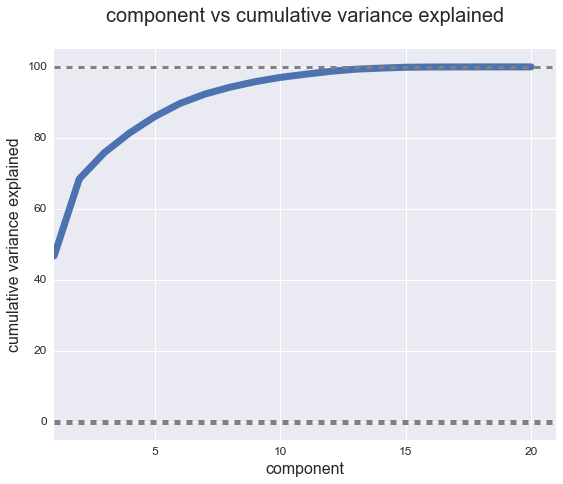

In [64]:
plt.figure(figsize=(9,7))

component_number = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

plt.plot(component_number, cum_var_exp, lw=7)

plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=100, linewidth=3, color='grey', ls='dashed')


ax = plt.gca()
ax.set_xlim([1,21])
ax.set_ylim([-5,105])

ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

In [65]:
PCA_set = PCA(n_components=3)
XPCA = PCA_set.fit_transform(Xpca)
PCdf = pd.DataFrame(XPCA, columns=['PC1','PC2','PC3'])

In [66]:
PCdf.head()

PC1       PC2       PC3
0  2.658765 -0.356247  0.999987
1  3.058550 -0.700638  0.814898
2  2.451006 -0.112166  0.366767
3  2.022363  0.062444  0.308438
4  2.606836 -0.326953  0.091743

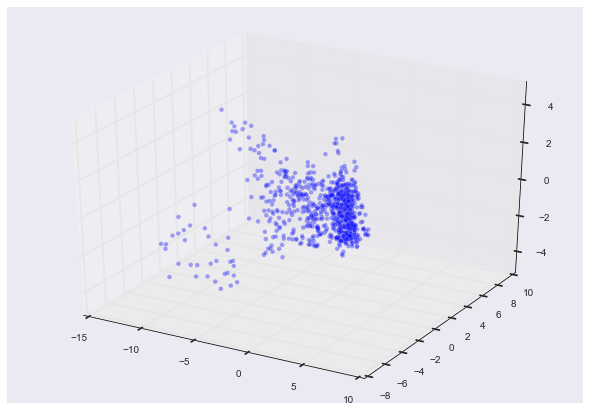

In [67]:
fig = pylab.figure()
ax = Axes3D(fig)
ax.scatter(PCdf['PC1'], PCdf['PC2'], PCdf['PC3'], zdir='z',alpha=.35, depthshade=True, )
plt.show()

In [68]:
airports2 = df[['airport', 'year']]
airport_pca = airports2.join(PCdf, on=None, how='left')

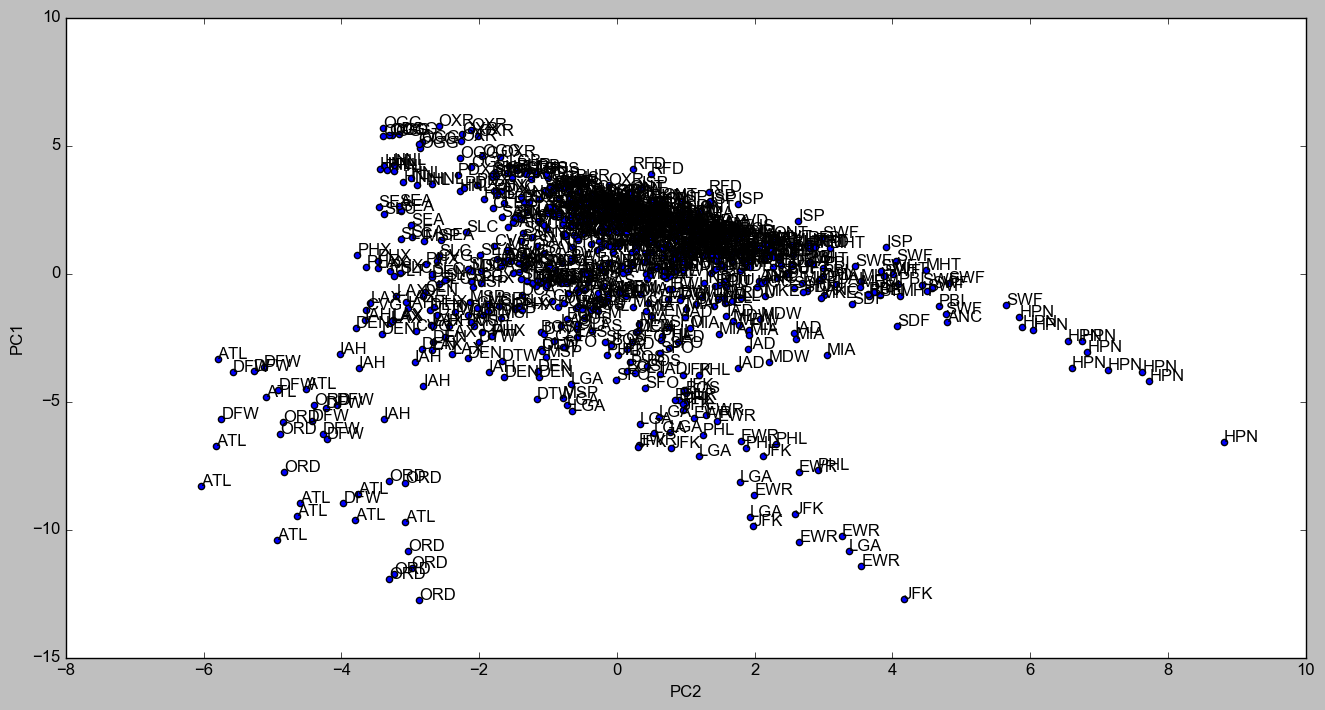

In [69]:
matplotlib.style.use('classic')

graph = airport_pca.plot(kind='scatter', x ='PC2', y = 'PC1',figsize=(16,8))

for i, airport in enumerate(df['airport']):
    graph.annotate(airport, (airport_pca.iloc[i].PC2, airport_pca.iloc[i].PC1))

In [70]:
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit(Xpca)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [71]:
airport_pca['cluster'] = pd.Series(clusters.labels_)

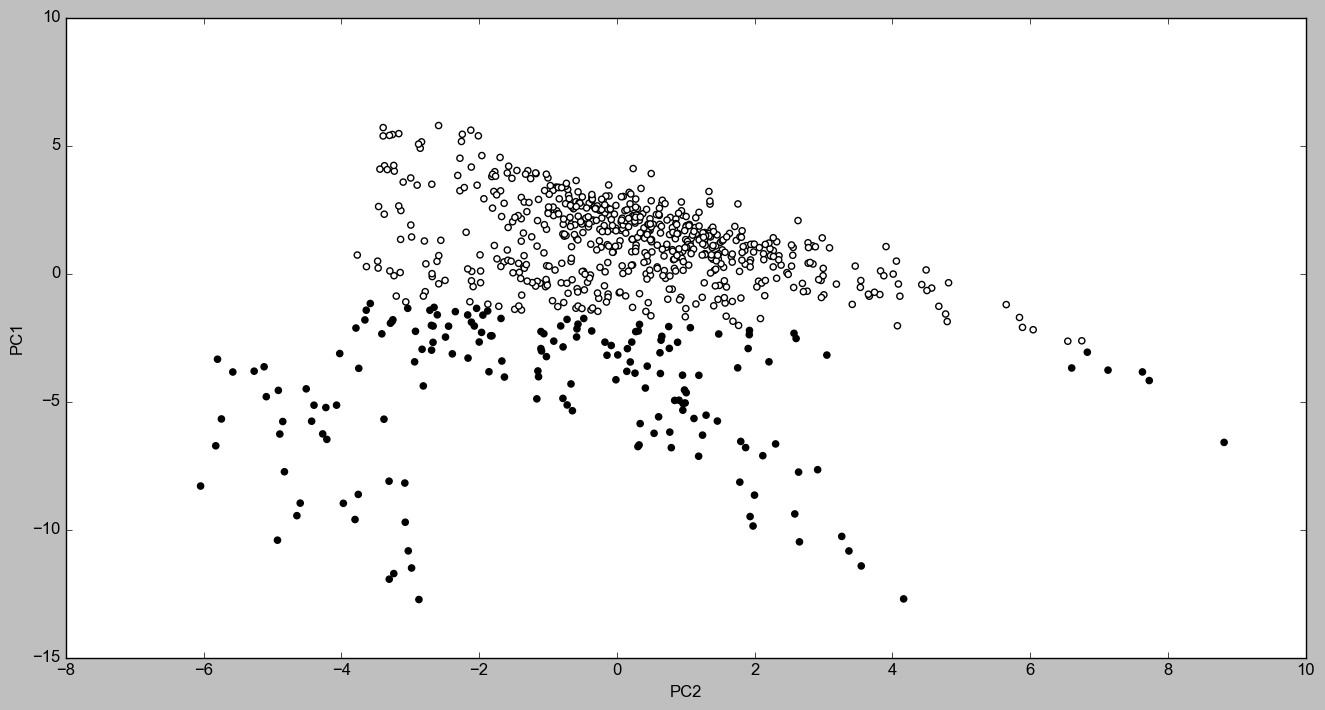

In [72]:
matplotlib.style.use('classic')

graph = airport_pca.plot(
    kind='scatter',
    x='PC2',y='PC1',
    c=airport_pca.cluster.astype(np.float), 
    figsize=(16,8))

In [73]:
X_pcs = X.copy()

X_pcs = (X - X.mean()) / X.std()

X_pcs['PC1'] = PCdf['PC1']
X_pcs['PC2'] = PCdf['PC2']
X_pcs['PC3'] = PCdf['PC3']

In [74]:
X_pcs = pd.melt(X_pcs, id_vars=['PC1','PC2','PC3'])
len(X_pcs)

15980

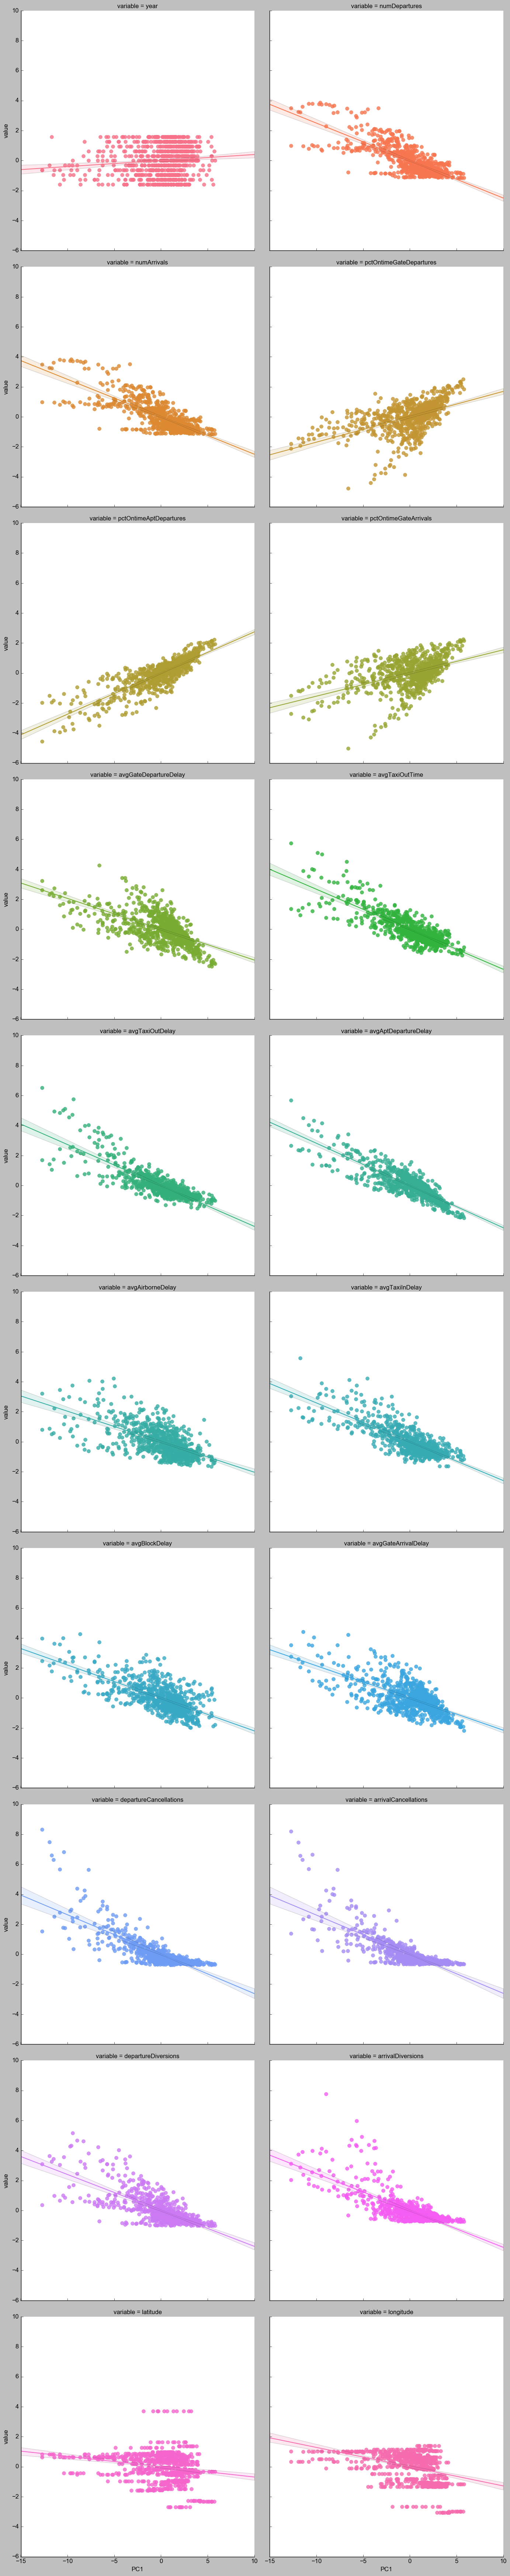

In [75]:
pc1 = sns.lmplot(x="PC1", y="value", col="variable", hue="variable", 
                 data=X_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

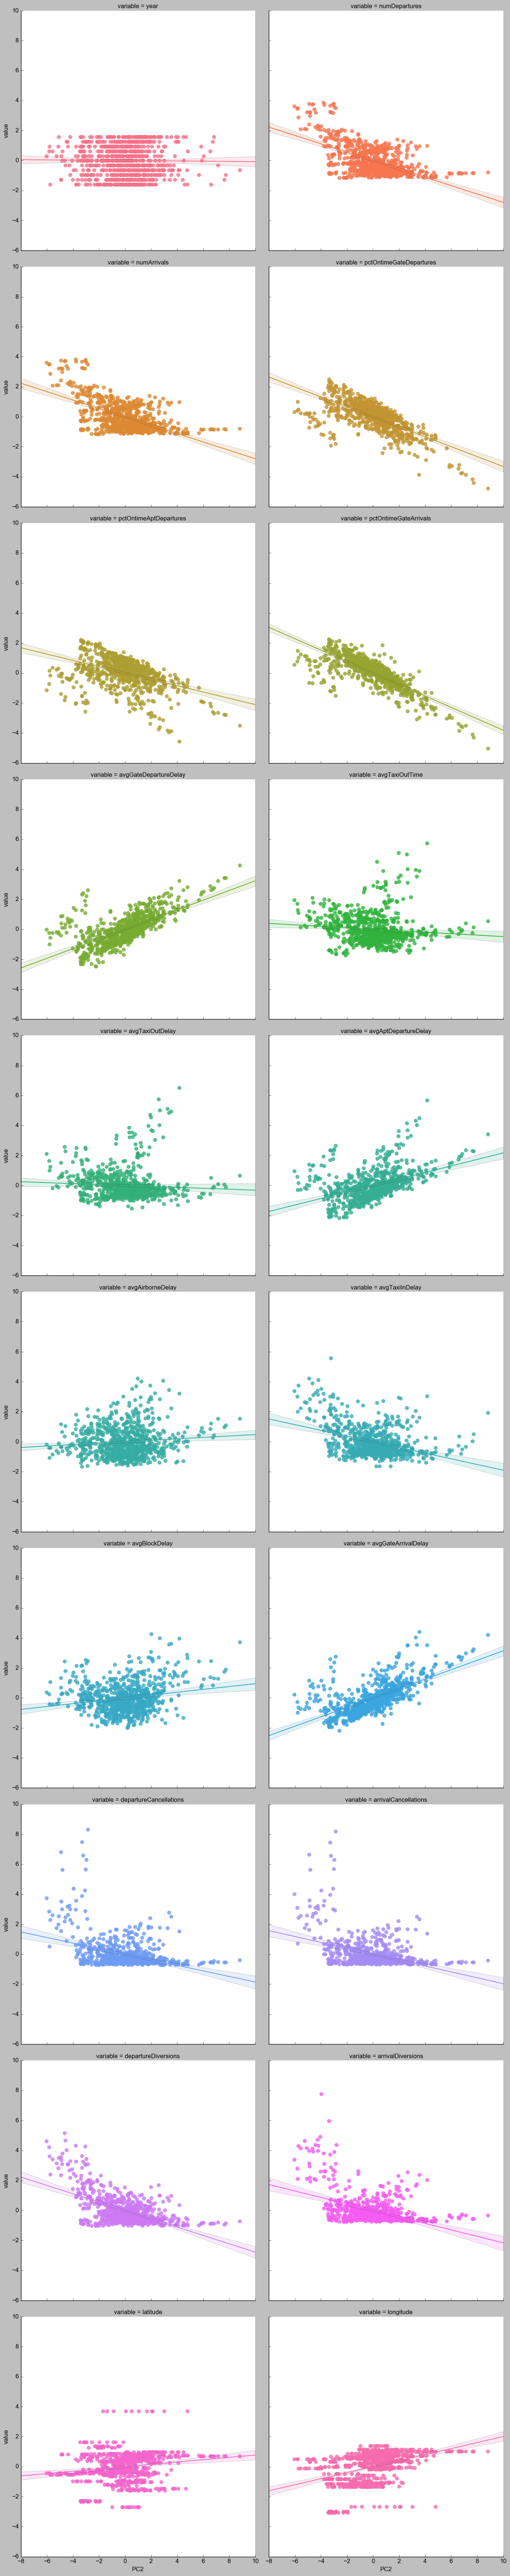

In [76]:
pc2 = sns.lmplot(x="PC2", y="value", col="variable", hue="variable", 
                 data=X_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

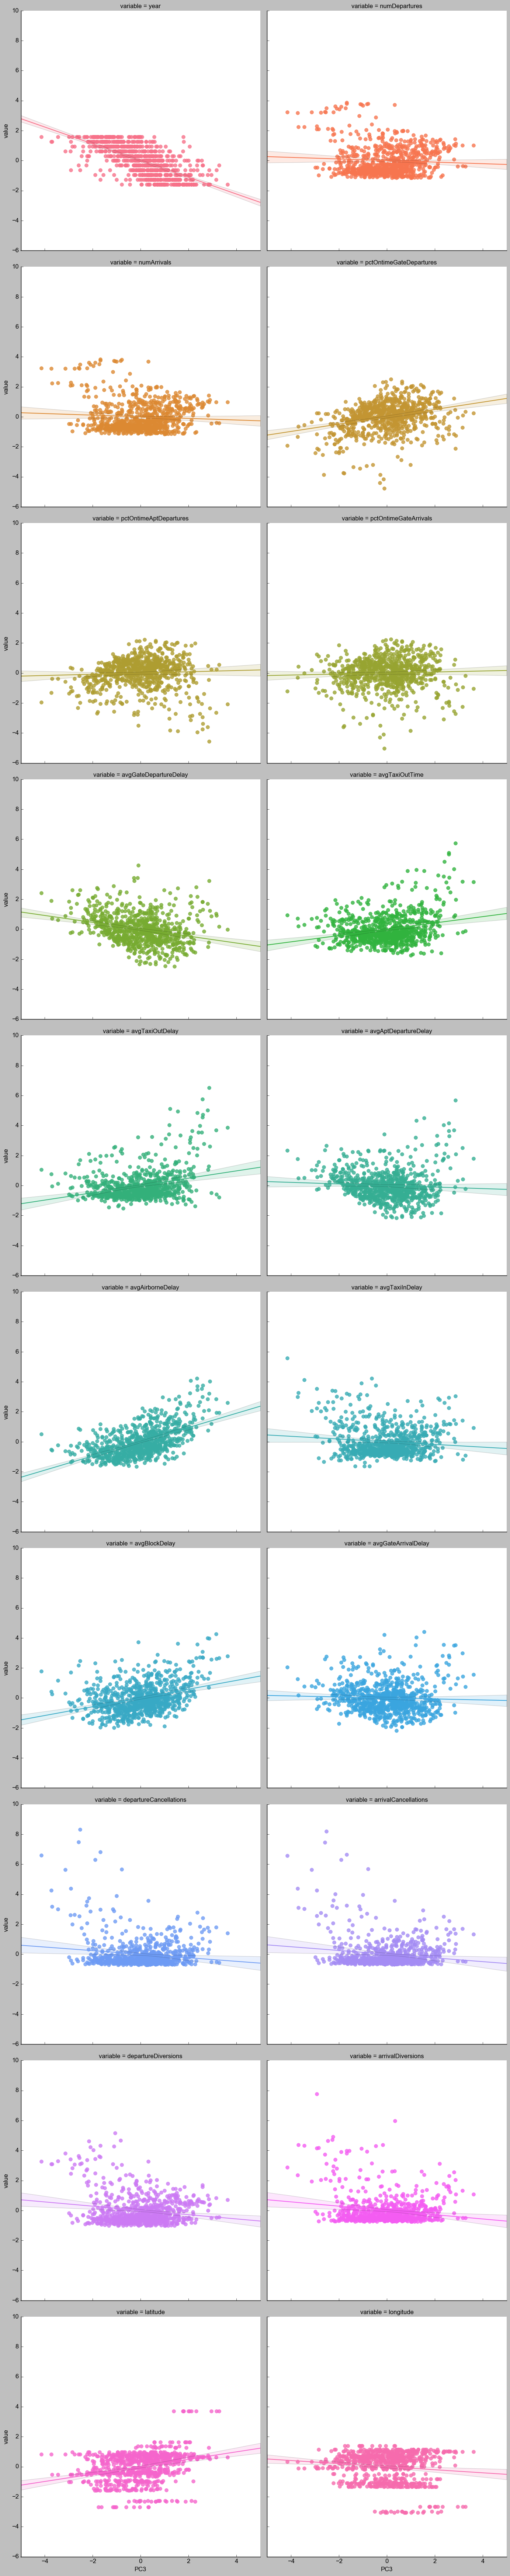

In [77]:
pc3 = sns.lmplot(x="PC3", y="value", col="variable", hue="variable", 
                 data=X_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

## Re-running the clustering analyses with our PCA stuff

In [78]:
s = []
i = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(PCdf)
    labels = kmeans.labels_
    s_i = silhouette_score(PCdf, labels, metric='euclidean')
    s.append(s_i)
    i.append(kmeans.inertia_)

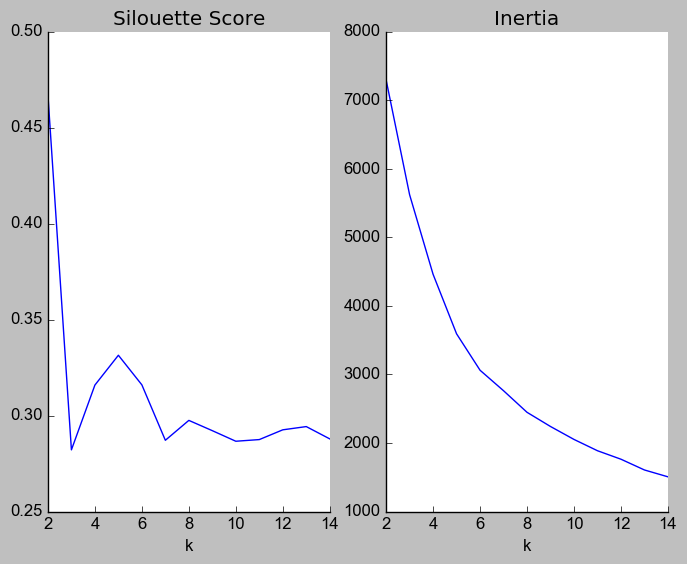

In [79]:
f, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(range(2,15), s)
ax1.set_title("Silouette Score")
ax1.set_xlabel("k")

ax2.plot(range(2,15), i)
ax2.set_title("Inertia")
ax2.set_xlabel("k")

sns.despine()

In [80]:
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(PCdf)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [81]:
PCdf['label']=labels

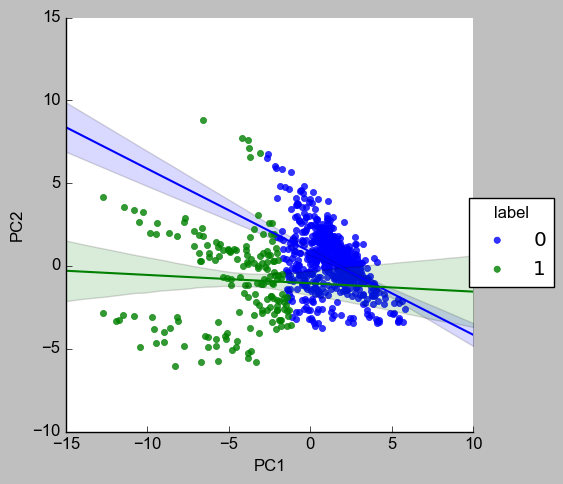

In [82]:
sns.lmplot('PC1', 'PC2', data=PCdf,  hue='label')

In [83]:
silhouette_score(PCdf,labels)

0.47438449579453362

## Hierarchical clustering with PCA

In [85]:
Xhpca =PCdf.as_matrix(columns=None)

In [86]:
Z = linkage(Xhpca, 'complete')

In [87]:
c, coph_dists = cophenet(Z, pdist(Xhpca))
c

0.72383570544925113

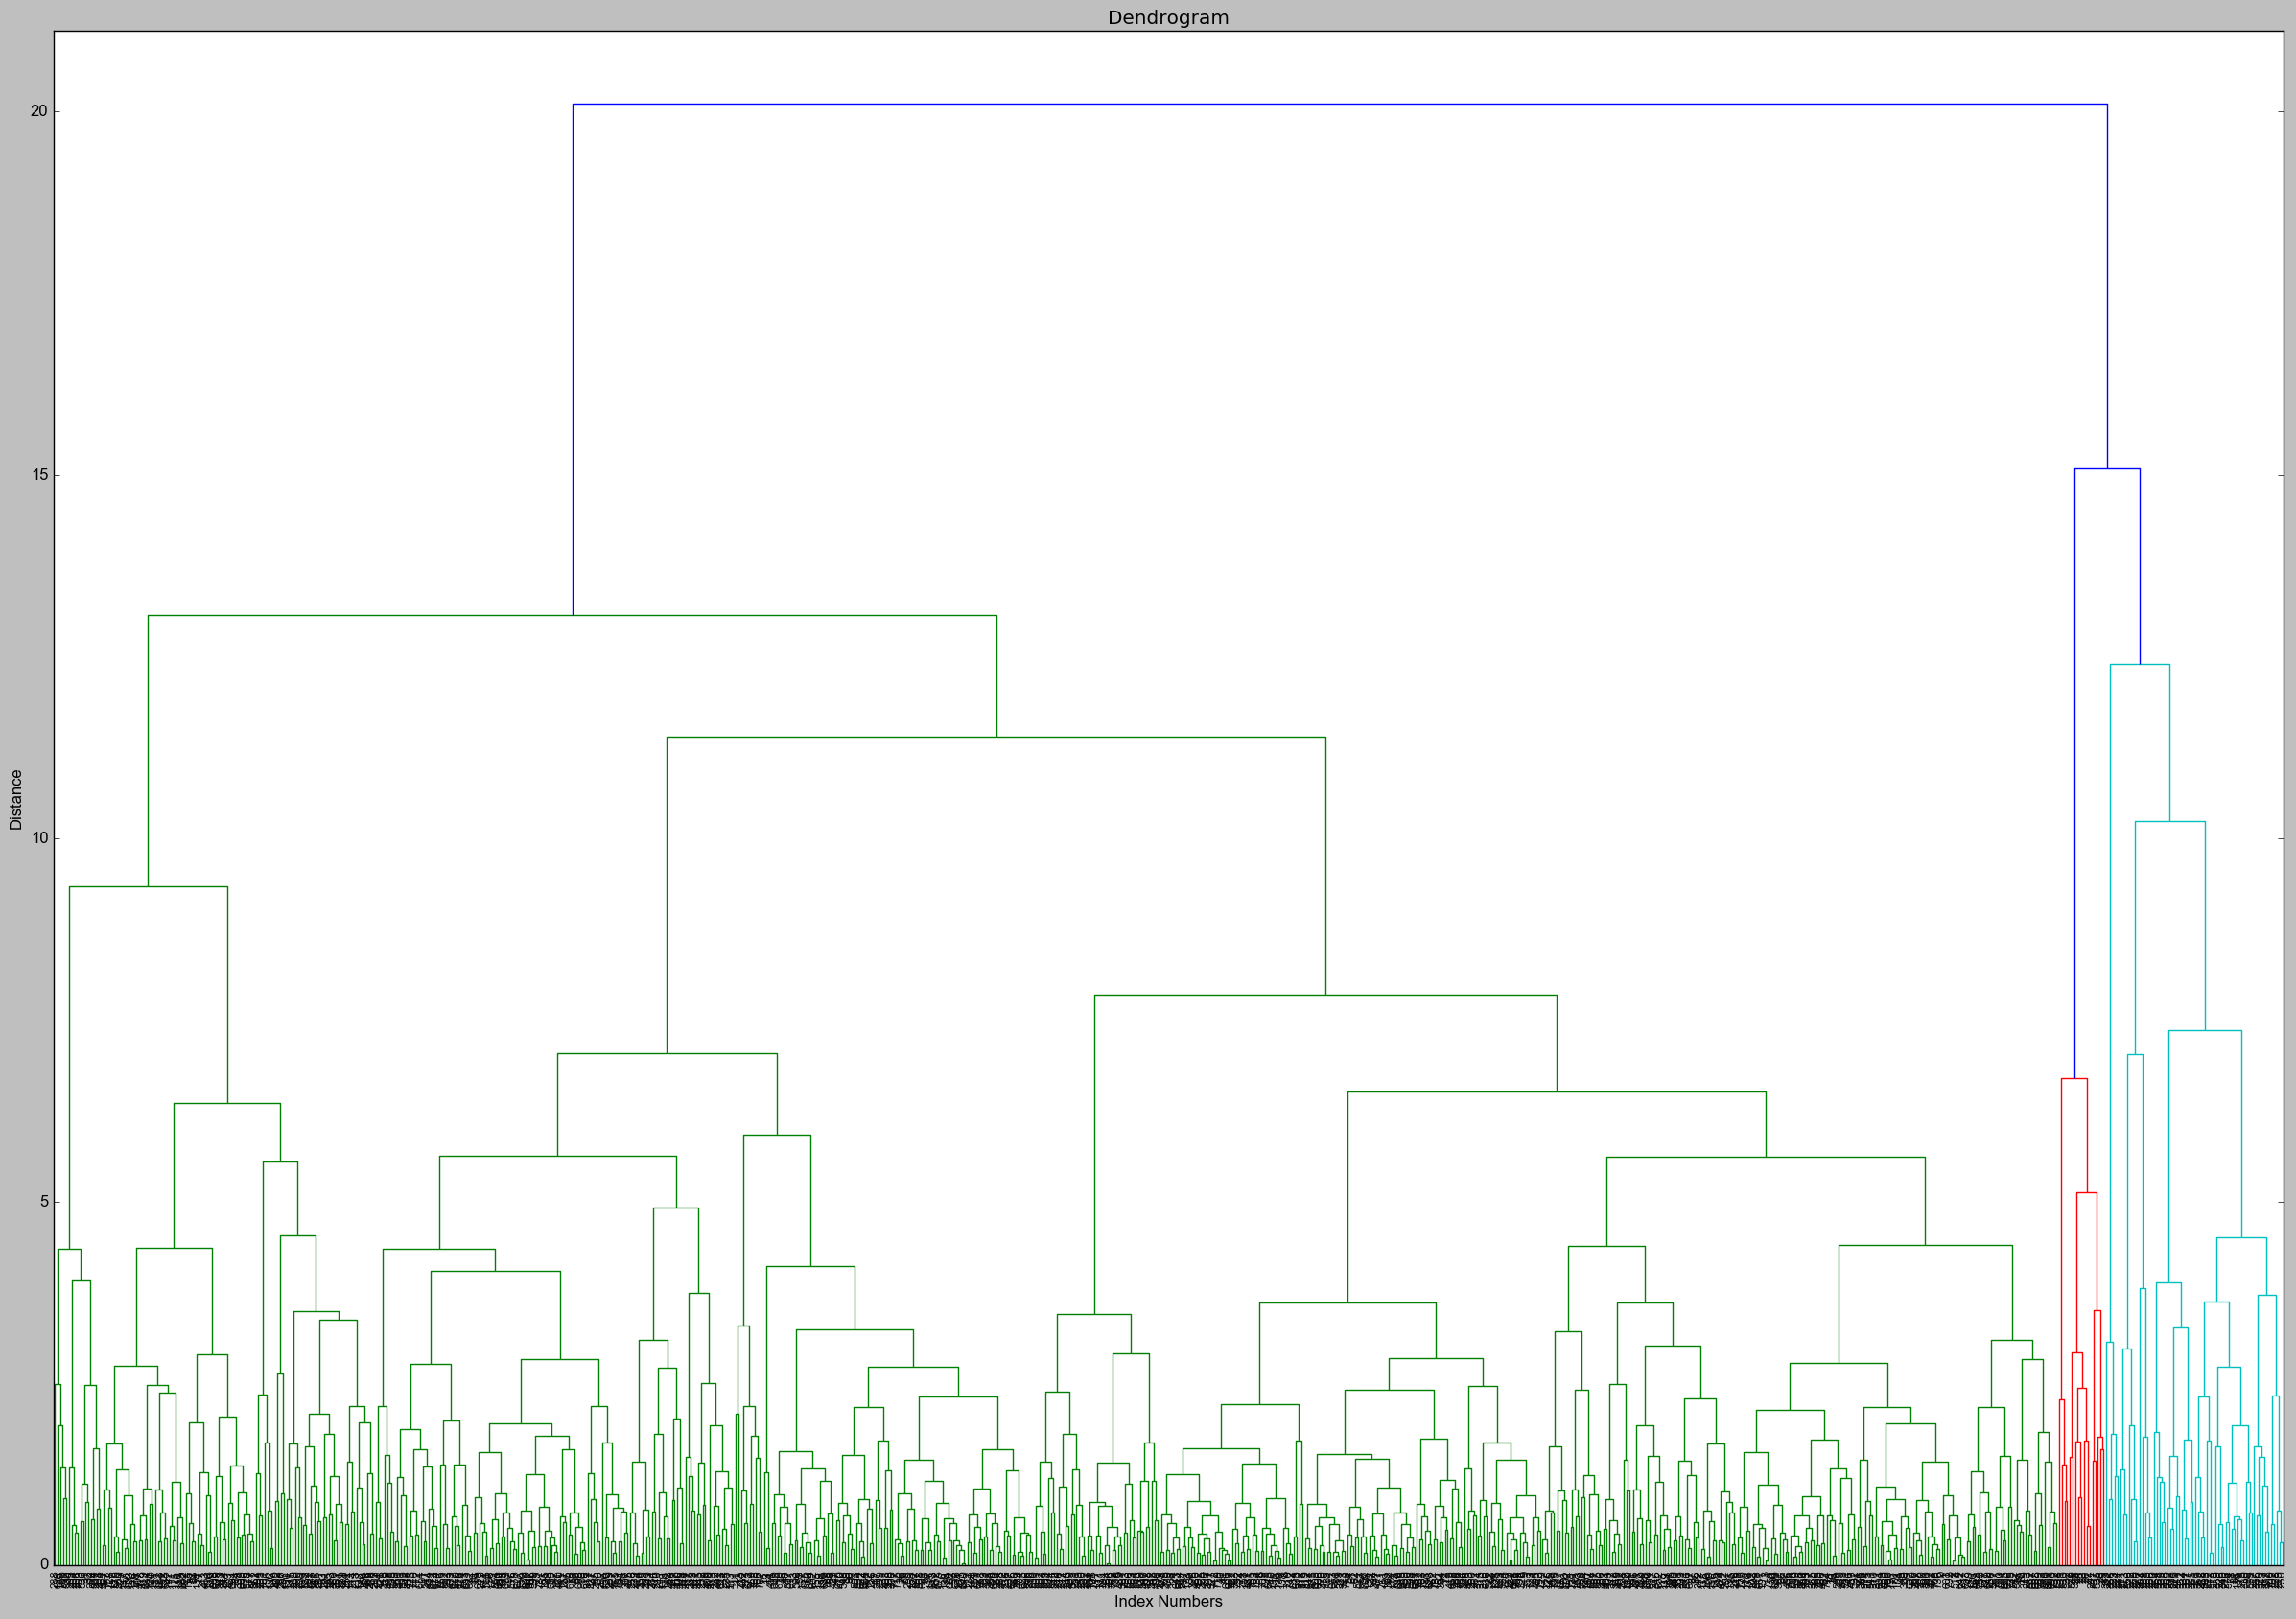

In [90]:
plt.figure(figsize=(30, 20))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

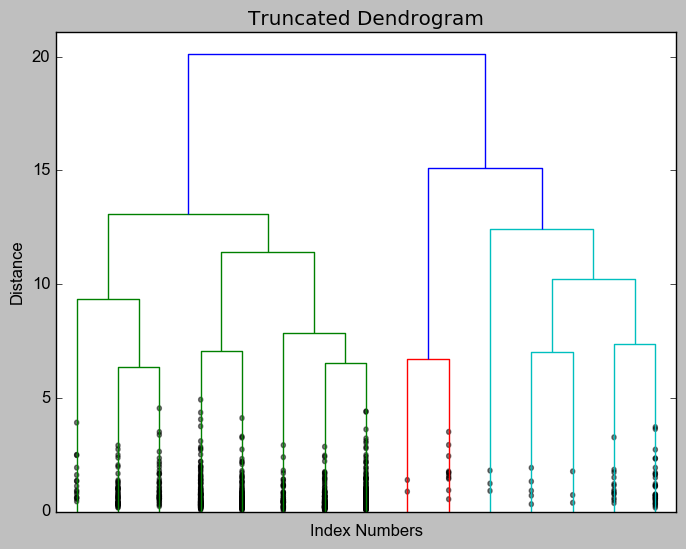

In [89]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=15,  
    show_leaf_counts=False,  
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

In [91]:
max_d = 20
clusters = fcluster(Z, max_d, criterion='distance')

In [92]:
silhouette_score(PCdf, clusters)

0.52024455721082974

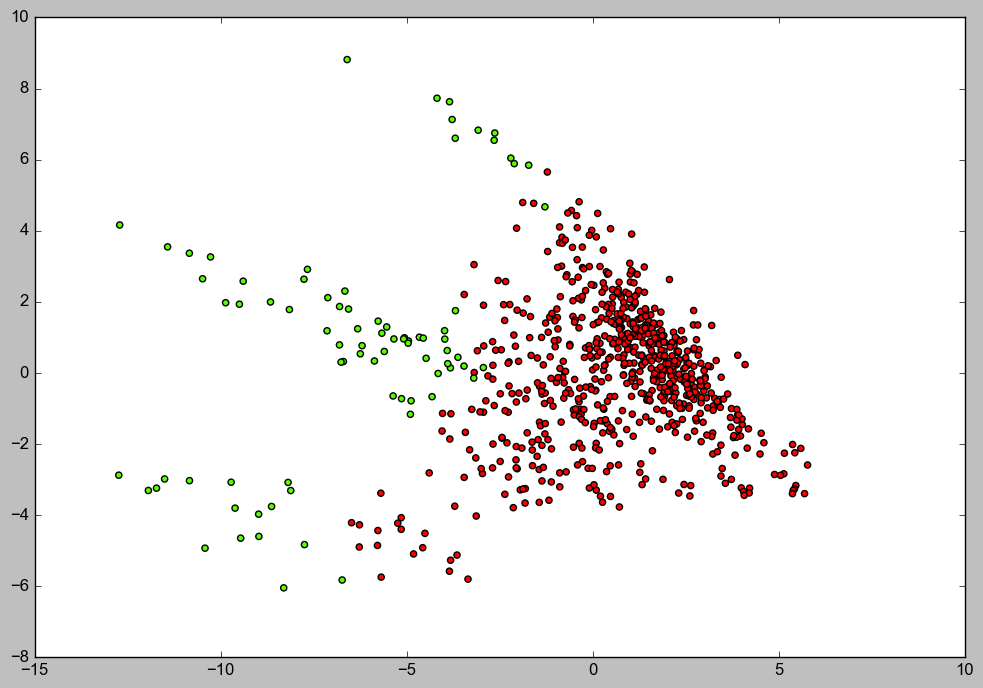

In [93]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(PCdf['PC1'], PCdf['PC2'], c=clusters, cmap='prism', s=20);

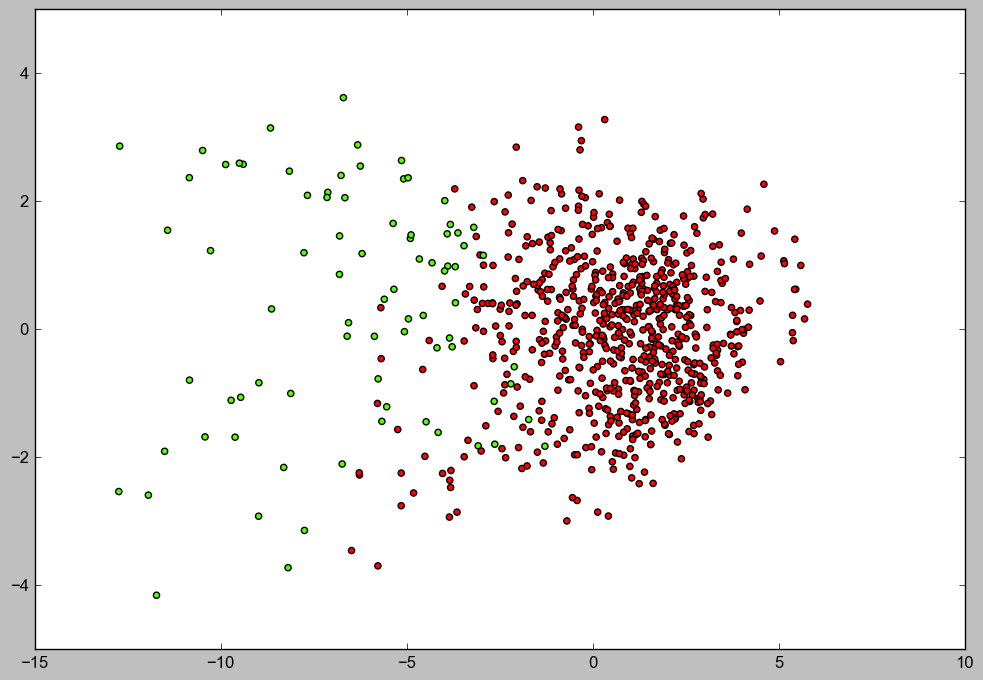

In [94]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(PCdf['PC1'], PCdf['PC3'], c=clusters, cmap='prism', s=20);

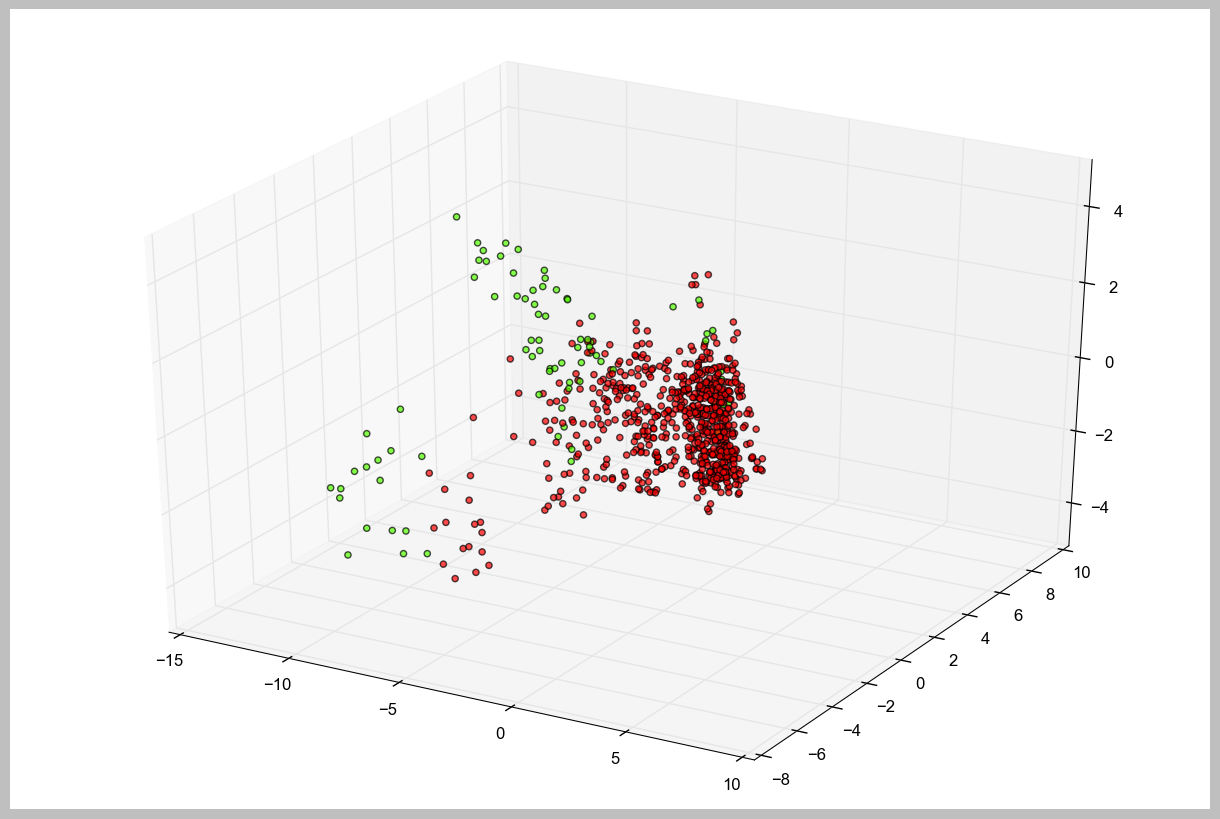

In [95]:
fig = pylab.figure(figsize=(12,8))
ax = Axes3D(fig)
ax.scatter(PCdf['PC1'], PCdf['PC2'],PCdf['PC3'], zdir='z',c=clusters,cmap='prism', alpha=.7, depthshade=True)
plt.show()

## Logistic Regression analysis with PCA features included

In [96]:
LRdf = pd.concat([X,PCdf],axis=1)
LRdf.drop('label',1,inplace=True)
LRdf.drop('latitude',1,inplace=True)
LRdf.drop('longitude',1,inplace=True)
X = LRdf
y = LabelEncoder().fit_transform(df['FAAregion'])

In [101]:
# generic curve plotting function
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title(curve_name + ' for house price > 200,000', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')

def plot_confusion_matrix(cm, title='Confusion matrix', labels= [1,2,3], cmap=plt.cm.Blues, t_number =2):
    
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(t_number)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()]) #The last line here adds a text outline

In [98]:
X_train, X_test, y_train, y_test = train_test_split(LRdf.values,y,test_size = 0.33,  random_state = 77)

In [99]:
logreg = LogisticRegression(random_state = 77)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

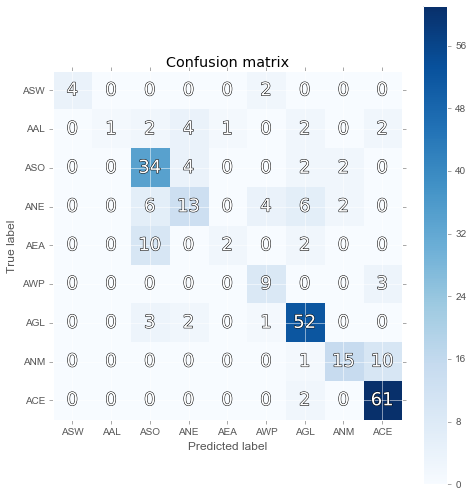

In [102]:
conmat = np.array(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(conmat,labels = df['FAAregion'].unique(), title='Confusion matrix', cmap=plt.cm.Blues,t_number =9)

In [108]:
# Accuracy tells us the percent of FAA regions correctly predicted
print("accuracy score: " + str(accuracy_score(y_test, y_pred)))

# Precision tells us how well the classifier avoided misclassifying FAA regions
print('precision score: ' + str(precision_score(y_test, y_pred)))

# Recall tells us how well the classifier correctly identified FAA regions
print('recall score: ' + str(recall_score(y_test, y_pred)))

accuracy score: 0.723484848485
precision score: 0.733620225241
recall score: 0.723484848485


/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="

## Random Forest classifier 

In [109]:
ranfor = RandomForestClassifier()
ranfor.fit(X_train, y_train)
y_pred = ranfor.predict(X_test)

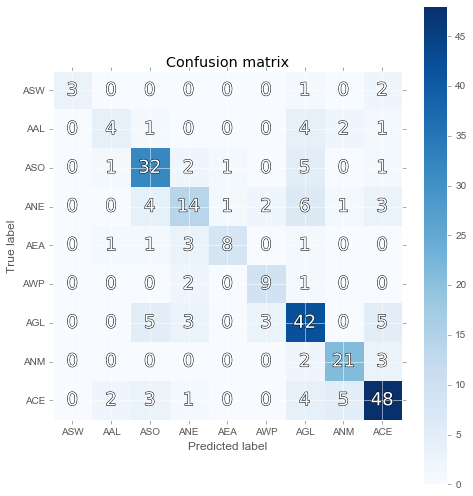

In [110]:
conmat = np.array(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(conmat,labels = df['FAAregion'].unique(), title='Confusion matrix', cmap=plt.cm.Blues,t_number =9)

In [111]:
# Accuracy tells us the percent of FAA regions correctly predicted
print("accuracy score: " + str(accuracy_score(y_test, y_pred)))

# Precision tells us how well the classifier avoided misclassifying FAA regions
print('precision score: ' + str(precision_score(y_test, y_pred)))

# Recall tells us how well the classifier correctly identified FAA regions
print('recall score: ' + str(recall_score(y_test, y_pred)))

accuracy score: 0.685606060606
precision score: 0.686471038389
recall score: 0.685606060606


/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="

In [112]:
ranfor.feature_importances_

array([ 0.01506132,  0.07163784,  0.05140274,  0.02735742,  0.02918185,
        0.03587958,  0.04064495,  0.09243831,  0.05263262,  0.05257276,
        0.04954931,  0.03579765,  0.04227346,  0.05516633,  0.03573774,
        0.03438001,  0.06809081,  0.06022944,  0.05039849,  0.05035121,
        0.04921614])

In [113]:
importances = pd.DataFrame(zip(ranfor.feature_importances_), index=X.columns,
                           columns=['rf_importance']).sort_values('rf_importance',
                            ascending=False)
importances.head(10)

rf_importance
avgTaxiOutTime             0.092438
numDepartures              0.071638
departureDiversions        0.068091
arrivalDiversions          0.060229
avgGateArrivalDelay        0.055166
avgTaxiOutDelay            0.052633
avgAptDepartureDelay       0.052573
numArrivals                0.051403
PC1                        0.050398
PC2                        0.050351

In [114]:
X.columns

Index([                   u'year',           u'numDepartures',
                   u'numArrivals', u'pctOntimeGateDepartures',
        u'pctOntimeAptDepartures',   u'pctOntimeGateArrivals',
         u'avgGateDepartureDelay',          u'avgTaxiOutTime',
               u'avgTaxiOutDelay',    u'avgAptDepartureDelay',
              u'avgAirborneDelay',          u'avgTaxiInDelay',
                 u'avgBlockDelay',     u'avgGateArrivalDelay',
        u'departureCancellations',    u'arrivalCancellations',
           u'departureDiversions',       u'arrivalDiversions',
                           u'PC1',                     u'PC2',
                           u'PC3'],
      dtype='object')

## Looking to predict long/short delays this time rather than FAA regions

In [116]:
# Changing our 'y' to reflect the new target
y = X['avgAptDepartureDelay'].apply(lambda x: 1 if x > np.median(X['avgAptDepartureDelay']) else 0)

In [117]:
# Getting rid of the columns in X that would be too directly correlated to our y
X.drop(['avgAptDepartureDelay'],1, inplace=True)
X.drop(['pctOntimeAptDepartures'],1, inplace=True)

In [118]:
X.columns

Index([                   u'year',           u'numDepartures',
                   u'numArrivals', u'pctOntimeGateDepartures',
         u'pctOntimeGateArrivals',   u'avgGateDepartureDelay',
                u'avgTaxiOutTime',         u'avgTaxiOutDelay',
              u'avgAirborneDelay',          u'avgTaxiInDelay',
                 u'avgBlockDelay',     u'avgGateArrivalDelay',
        u'departureCancellations',    u'arrivalCancellations',
           u'departureDiversions',       u'arrivalDiversions',
                           u'PC1',                     u'PC2',
                           u'PC3'],
      dtype='object')

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 77, stratify = y)

In [120]:
ranfor = RandomForestClassifier()
ranfor.fit(X_train, y_train)
y_pred = ranfor.predict(X_test)

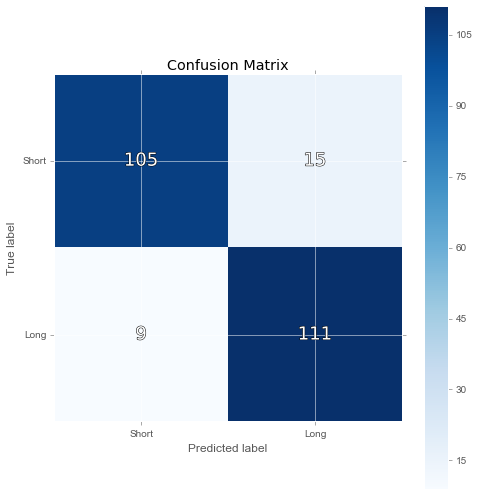

In [121]:
conmat = np.array(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(conmat, labels = ['Short','Long'], title = 'Confusion Matrix')

In [122]:
print classification_report(y_test,y_pred)

             precision    recall  f1-score   support

          0       0.92      0.88      0.90       120
          1       0.88      0.93      0.90       120

avg / total       0.90      0.90      0.90       240



In [124]:
# Accuracy tells us the percent of long/short delays predicted
print("accuracy score: " + str(accuracy_score(y_test, y_pred)))

# Precision tells us how well the classifier avoided misclassifying length of delays
print('precision score: ' + str(precision_score(y_test, y_pred)))

# Recall tells us how well the classifier correctly identified long/short delays
print('recall score: ' + str(recall_score(y_test, y_pred)))

accuracy score: 0.9
precision score: 0.880952380952
recall score: 0.925


In [126]:
importances = pd.DataFrame(zip(ranfor.feature_importances_), index=X.columns,
                           columns=['rf_importance']).sort_values('rf_importance',
                            ascending=False)
importances.head(10)

rf_importance
avgGateDepartureDelay         0.255481
pctOntimeGateDepartures       0.234410
PC1                           0.139690
departureCancellations        0.054269
PC2                           0.048826
avgGateArrivalDelay           0.043776
pctOntimeGateArrivals         0.036386
avgTaxiOutDelay               0.032714
avgTaxiOutTime                0.026057
arrivalCancellations          0.024872

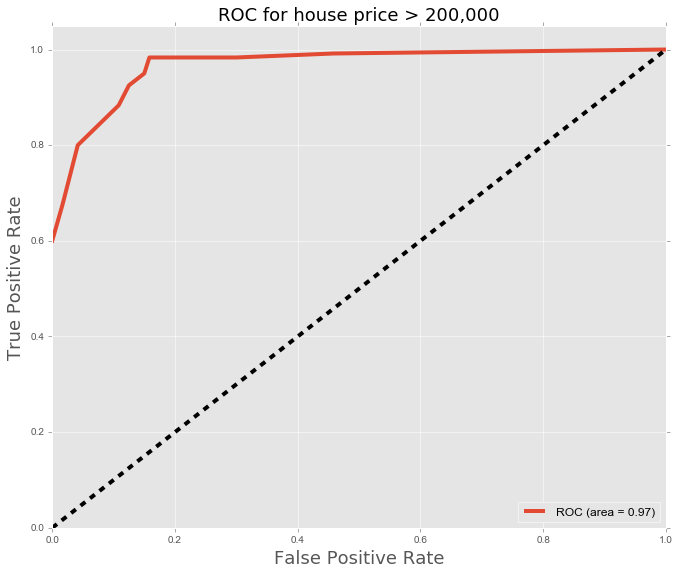

In [127]:
y_score = ranfor.predict_proba(X_test).T[1]
plot_roc(y_test, y_score)